In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D



import shutil
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.preprocessing import image

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.utils import shuffle

In [2]:
#train and test image data set directory paths

# Dataset for this program was downloaded to desktop from https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset

train_img_dir = "input/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train"
test_img_dir = "input/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test"



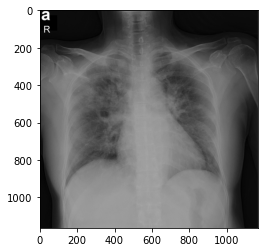

In [3]:
#visualize an image in the training set
train_list = []
for image_path in glob.glob(train_img_dir + "/*"):
    img = Image.open(image_path)
    train_list.append(img)
    
fig = plt.figure()
plt.imshow(train_list[2], cmap = "gray")

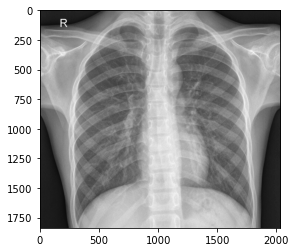

In [4]:
#Visualize an image in the test set
test_list = []
for image_path in glob.glob(test_img_dir + "/*"):
    img = Image.open(image_path)
    test_list.append(img)
    
fig = plt.figure()
plt.imshow(test_list[2], cmap = "gray")

In [5]:
print("There are " + str(len(test_list)) + " images in the test set")
print("There are " + str(len(train_list)) + " images in the training set")

There are 626 images in the test set
There are 5311 images in the training set


In [6]:
#print sizes of all images in the list

img_sizes = []

for img in train_list: #test_list

    size = img.size
    img_sizes.append(size)
 #   pixels = np.asarray(img)
 #   print('Data Type: %s' % pixels.dtype)
 #   print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
print(img_sizes)

[(1989, 1482), (2563, 1148), (1165, 1163), (1170, 1161), (1165, 1165), (1166, 1161), (1183, 923), (1178, 922), (1183, 931), (1178, 930), (477, 411), (508, 500), (439, 362), (445, 362), (436, 391), (439, 391), (1641, 1668), (2059, 1483), (1899, 1464), (1696, 1403), (512, 512), (1726, 1552), (4248, 3480), (1884, 1447), (1024, 1024), (1427, 1542), (1764, 1668), (1727, 1442), (2024, 1523), (255, 249), (256, 247), (2500, 2048), (1245, 1240), (1024, 1024), (1657, 1530), (1723, 1466), (2836, 2336), (1384, 1326), (1206, 1263), (1206, 1263), (1992, 1285), (1793, 1479), (1249, 1243), (1024, 842), (4200, 3408), (1458, 1303), (1024, 842), (1799, 1472), (657, 657), (1206, 1263), (1592, 1448), (651, 659), (2494, 2048), (999, 816), (629, 708), (1492, 1613), (1024, 842), (1873, 1500), (4248, 3480), (1598, 1550), (1560, 1668), (1024, 1024), (1677, 1611), (2061, 1369), (1206, 1263), (1024, 1024), (683, 685), (781, 750), (2090, 1858), (1422, 1152), (1810, 1434), (1618, 1279), (1600, 1125), (1974, 1306), 

In [7]:
# Information about data set
df_metadata = pd.read_csv("input/Chest_xray_Corona_Metadata.csv")
df_metadata.head()

#Label column is the target column for prediction 

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [8]:
set(df_metadata["Label"])  # two label: binary classification

{'Normal', 'Pnemonia'}

In [9]:
#divide train & test metadata
train_df = df_metadata[df_metadata["Dataset_type"] == "TRAIN"]
test_df = df_metadata[df_metadata["Dataset_type"] == "TEST"]


In [10]:

train_df.shape, test_df.shape

((5286, 6), (624, 6))

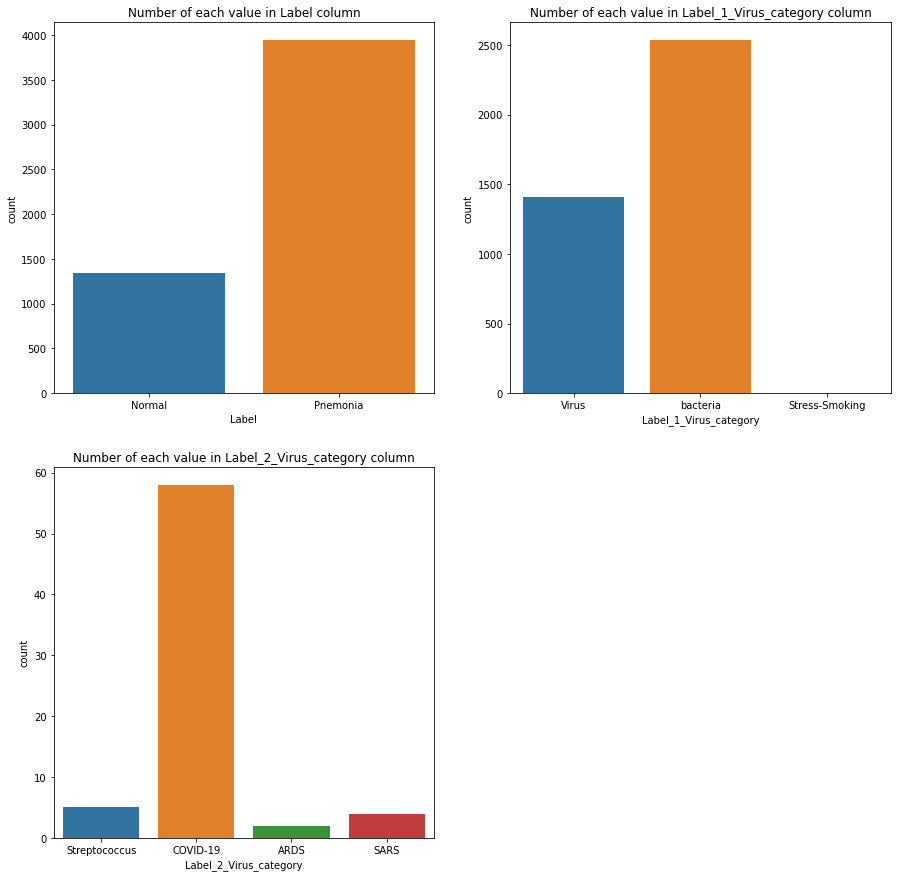

In [11]:
col = ['Label', 'Label_1_Virus_category', 'Label_2_Virus_category']

fig = plt.figure(figsize=(15, 15))
for i in range(3):
    ax = plt.subplot(2, 2, i + 1)
    ax = sns.countplot(x = col[i], data = train_df)
    ax.set_title(f'Number of each value in {col[i]} column')
plt.show()

In [12]:
train_df.fillna("unknown", inplace = True )
test_df.fillna("unknown", inplace = True )

In [13]:
train_df["Label_2_Virus_category"].value_counts()


unknown          5217
COVID-19           58
Streptococcus       5
SARS                4
ARDS                2
Name: Label_2_Virus_category, dtype: int64

In [14]:
train_df["Label_1_Virus_category"].value_counts()

bacteria          2535
Virus             1407
unknown           1342
Stress-Smoking       2
Name: Label_1_Virus_category, dtype: int64

In [15]:
# Function creates working directories for labelled images

def create_dir():   
    try:
        os.makedirs('working/train/Pnemonia')
        os.makedirs('working/train/Normal')
        os.makedirs('working/test/Pnemonia')
        os.makedirs('working/test/Normal')
    except:
        pass

In [16]:
create_dir()  # call function

In [17]:
# Move training data with labels Pnemonia and Normal to created directiories

#COVID-19 case
train_pnemonia ='working/train/Pnemonia'
move_train_pnemonia = train_df[train_df.Label == 'Pnemonia']['X_ray_image_name'].values
for i in tqdm(move_train_pnemonia):
    path = os.path.join(train_img_dir,i)
    shutil.copy(path, train_pnemonia)
    
#Normal cases 
train_normal =  'working/train/Normal'
move_train_normal = train_df[train_df.Label == 'Normal']['X_ray_image_name'].values
for i in tqdm(move_train_normal):
    path = os.path.join(train_img_dir,i)
    shutil.copy(path, train_normal)

100%|█████████████████████████████████████████████████████████████████████████████| 1342/1342 [00:08<00:00, 164.64it/s]


In [18]:
# Move test data with labels Pnemonia and Normal to created directiories


#COVID-19 cases
test_pnemonia = 'working/test/Pnemonia'
move_test_pnemonia = test_df[test_df.Label == 'Pnemonia']['X_ray_image_name'].values
for i in tqdm(move_test_pnemonia):
    path = os.path.join(test_img_dir,i)
    shutil.copy(path,test_pnemonia)

#Normal cases
test_normal = 'working/test/Normal'
move_test_normal = test_df[test_df.Label == 'Normal']['X_ray_image_name'].values
for i in tqdm(move_test_normal):
    path = os.path.join(test_img_dir,i)
    shutil.copy(path, test_normal)

100%|███████████████████████████████████████████████████████████████████████████████| 234/234 [00:00<00:00, 344.95it/s]


In [19]:
# Model configuration
batch_size = 64
img_width, img_height, img_num_channels = 224,224,3
epochs = 10
verbosity = 1
input_shape = (img_width, img_height, img_num_channels)

In [20]:
# Function to build, compile and train the model

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   rotation_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   validation_split=0.2)
train_generator = train_datagen.flow_from_directory('working/train/',
                                                    target_size=(224,224),
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    subset = 'training')

valid_generator = train_datagen.flow_from_directory('working/train/',
                                                    target_size=(224,224),
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    subset = 'validation')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory('working/test/',
                                                  batch_size=batch_size,
                                                  class_mode='binary')

Found 4230 images belonging to 2 classes.
Found 1056 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [21]:
# Modelling


model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3),  activation = "relu",   padding = "same",  input_shape = (224,224,3)))
model.add(layers.BatchNormalization()) 
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (3,3), activation = "relu", padding = "same"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128, (3,3),  activation = "relu", padding = "same"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Flatten())   
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1024, activation = "relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation = "sigmoid"))


    
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       7

In [22]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_generator, validation_data = valid_generator,  epochs=10)

Epoch 1/10
67/67 [==============================] - 629s 9s/step - loss: 5.7000 - accuracy: 0.8186 - val_loss: 69.5108 - val_accuracy: 0.7462
Epoch 2/10
67/67 [==============================] - 621s 9s/step - loss: 2.0419 - accuracy: 0.8706 - val_loss: 67.8160 - val_accuracy: 0.7462
Epoch 3/10
67/67 [==============================] - 468s 7s/step - loss: 1.0075 - accuracy: 0.8765 - val_loss: 75.1287 - val_accuracy: 0.7462
Epoch 4/10
67/67 [==============================] - 462s 7s/step - loss: 0.7429 - accuracy: 0.8942 - val_loss: 77.2935 - val_accuracy: 0.7462
Epoch 5/10
67/67 [==============================] - 462s 7s/step - loss: 0.5230 - accuracy: 0.8846 - val_loss: 51.1324 - val_accuracy: 0.7462
Epoch 6/10
67/67 [==============================] - 454s 7s/step - loss: 0.3997 - accuracy: 0.8959 - val_loss: 17.3081 - val_accuracy: 0.7462
Epoch 7/10
67/67 [==============================] - 465s 7s/step - loss: 0.4134 - accuracy: 0.9029 - val_loss: 6.2206 - val_accuracy: 0.7472
Epoch 8

In [23]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]


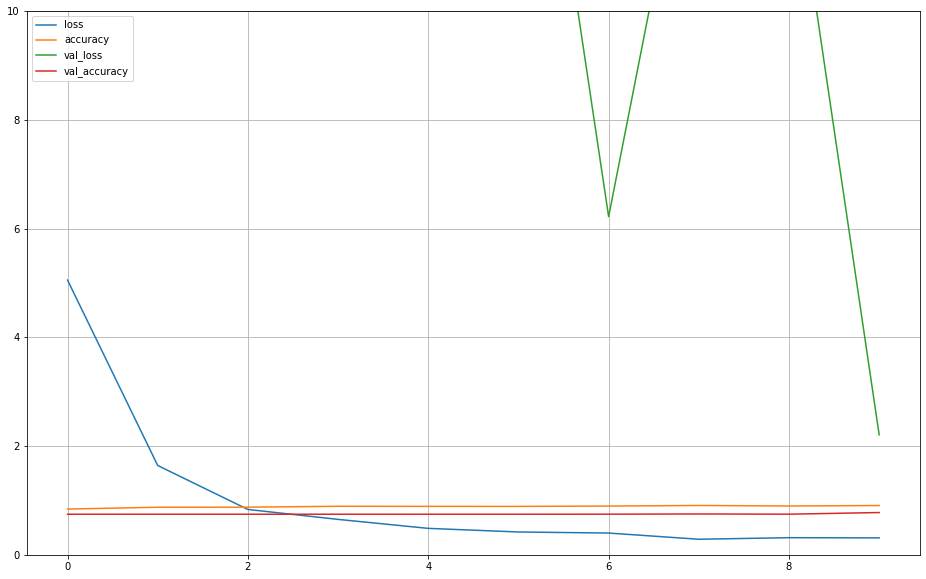

In [30]:
  #learning curves

pd.DataFrame(history.history).plot(figsize = (16, 10))
plt.grid(True)
plt.gca().set_ylim(0, 10)
plt.show()


# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

 # fmt = '.2f' if normalize else 'd'
 # thresh = cm.max() / 2.
 # for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
 #     plt.text(j, i, format(cm[i, j], fmt),
 #              horizontalalignment="center",
 #              color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [32]:
#predict the test data
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

pred = model.predict(test_generator)

y_pred = np.argmax(pred,axis=1)
y_test = test_generator.labels
print('Classification report:\n', classification_report(y_test, y_pred))
print('Accuracy score:\n', accuracy_score(y_test, y_pred))

InvalidArgumentError:  Input to reshape is a tensor with 8388608 values, but the requested shape requires a multiple of 100352
	 [[node sequential/flatten/Reshape (defined at <ipython-input-25-f23a27fdffcb>:2) ]] [Op:__inference_predict_function_3839]

Function call stack:
predict_function
